In [1]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from SinkhornImputation import SinkhornImputation
from Sinkhorn_CMI import SinkhornImputation_CMI
from RR_imputer import RRimputer
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [3]:
Xy = {}
with open(r'C:\Users\zhossai3\Desktop\My code\OT+Fairness\Data\Heart Failour\heart_failour.csv', 'rb') as f:
        df = pd.read_csv(f, delimiter=',', header = 0)
        Xy['data'] = df.values[:, :-1].astype('float')
        Xy['target'] =  df.values[:, -1]

In [4]:
ground_truth_numpy = scale(Xy['data'])
print(type(ground_truth_numpy))

<class 'numpy.ndarray'>


In [5]:
print(np.max(ground_truth_numpy))
print(np.min(ground_truth_numpy))
print(np.mean(ground_truth_numpy))
print(np.median(ground_truth_numpy))
print(np.std(ground_truth_numpy))

4.983762314391507
-7.154995235672277
5.418081863094446e-17
-0.2675958608301924
1.0


In [6]:
print(ground_truth_numpy)

[[-1.4331398  -0.51595242 -1.70557305 ... -0.8235563  -0.83243239
  -1.05211381]
 [-0.47848359  1.93816322 -0.53099236 ... -0.8235563   0.10566353
   0.59607813]
 [-1.75135854 -0.51595242 -1.70557305 ... -0.8235563  -0.83243239
  -1.05211381]
 ...
 [ 0.37009972 -0.51595242  0.64358833 ...  1.21424608  0.29328271
   0.59607813]
 [ 0.37009972  1.93816322 -1.70557305 ... -0.8235563  -0.83243239
   0.59607813]
 [-1.64528563 -0.51595242 -0.53099236 ... -0.8235563  -0.83243239
  -1.05211381]]


In [7]:
print(ground_truth_numpy.shape)
ground_truth = torch.from_numpy(ground_truth_numpy)
print(ground_truth.isnan().sum())

(918, 11)
tensor(0)


In [8]:
#30% MCAR
np.random.seed(42)

p_macr30 = 0.301


mask_mcar30 = np.random.rand(*ground_truth.shape) < p_macr30  # True for missing values, false for others
data_mcar30 = np.copy(ground_truth)

# Apply the mask to set the selected values to NaN
data_mcar30[mask_mcar30] = np.nan

# Convert to a torch tensor
data_mcar30 = torch.from_numpy(data_mcar30)

# Calculate the percentage of missing values
missing_values_mcar30 = torch.isnan(data_mcar30)  # Create a boolean tensor where NaNs are True
missing_percentage_mcar30 = torch.sum(missing_values_mcar30).item() / data_mcar30.numel() * 100  # Calculate the percentage of NaNs
print(f"Percentage of missing values: {missing_percentage_mcar30:.2f}%")

Percentage of missing values: 30.58%


In [9]:
data_mcar30_numpy = data_mcar30.detach().cpu().numpy()

In [10]:
#sinkhorn
n_mcar30, d_mcar30 = data_mcar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
#epsilon_mcar30 = pick_epsilon(data_mcar30)
epsilon_mcar30 = 0.3
print(epsilon_mcar30)


0.3


In [11]:
sk_imputer_mcar30 = SinkhornImputation_CMI(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar,sk_loss_mcar30 = sk_imputer_mcar30.fit_transform(data_mcar30, verbose=True, report_interval=50, X_true=ground_truth)
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30_numpy,ground_truth_numpy ,mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30_numpy, ground_truth_numpy,mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

INFO:root:Iteration 0:	 Loss: 1.9367	 Validation MAE: 0.8431	RMSE: 0.9999
INFO:root:Iteration 50:	 Loss: 1.5578	 Validation MAE: 0.7671	RMSE: 0.9779
INFO:root:Iteration 100:	 Loss: 1.6491	 Validation MAE: 0.7387	RMSE: 0.9735
INFO:root:Iteration 150:	 Loss: 1.7652	 Validation MAE: 0.7203	RMSE: 0.9719
INFO:root:Iteration 200:	 Loss: 1.5384	 Validation MAE: 0.7098	RMSE: 0.9711
INFO:root:Iteration 250:	 Loss: 1.5480	 Validation MAE: 0.7012	RMSE: 0.9701
INFO:root:Iteration 300:	 Loss: 1.6003	 Validation MAE: 0.6969	RMSE: 0.9720
INFO:root:Iteration 350:	 Loss: 1.9432	 Validation MAE: 0.6924	RMSE: 0.9720
INFO:root:Iteration 400:	 Loss: 1.6590	 Validation MAE: 0.6882	RMSE: 0.9724
INFO:root:Iteration 450:	 Loss: 1.7237	 Validation MAE: 0.6882	RMSE: 0.9755
INFO:root:Iteration 500:	 Loss: 1.5162	 Validation MAE: 0.6857	RMSE: 0.9747
INFO:root:Iteration 550:	 Loss: 1.7288	 Validation MAE: 0.6837	RMSE: 0.9753
INFO:root:Iteration 600:	 Loss: 1.8153	 Validation MAE: 0.6813	RMSE: 0.9756
INFO:root:Itera

0.6724300742600461 0.9790784351461558


In [12]:
print(sk_loss_mcar30)
#sk_loss_mcar30.clear

[1.9366650591568741, 1.5577539319401814, 1.6490630057339875, 1.7651987606970088, 1.5384499141348815, 1.548016590936709, 1.6003356254036203, 1.943211665952588, 1.6589514903723992, 1.723679477299961, 1.5162417090603522, 1.7287757601272624, 1.8152854538867698, 1.4845493100436347, 2.0372226473677917, 1.7831218380734066, 1.735841755764627, 1.4717815185392884, 1.6025213405357015, 1.7097410836039797, 1.6046539856055062, 1.7210272447628083, 1.6018919404051148, 1.6818985224791545, 1.871316066557594, 1.7762213039995043, 1.920745299593185, 2.0066654695032358, 1.6561642313988225, 1.7776352649794804, 1.7101739194514067, 1.7239872747109728, 1.5199375485043, 1.5225128817256015, 1.66288507364178, 1.7546743058435874, 1.87276456960412, 1.5343492280270583, 1.7879069323726773, 1.7272042106206567]


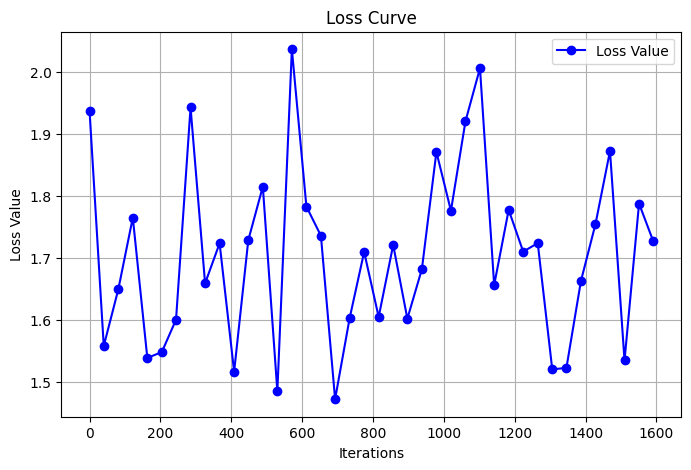

In [13]:
# Convert the list of losses to a NumPy array

iterations = np.linspace(0, 2000, 50).astype(int)



loss_values = sk_loss_mcar30


# Assuming cmi_penalty_history is also a list, convert it to a NumPy array
#cmi_penalty_history_numpy = np.array(cmi_penalty_history)

# Total loss calculation
#total_loss = sk_loss_mcar30_numpy + cmi_penalty_history_numpy
if len(loss_values) > len(iterations):
    loss_values = loss_values[:len(iterations)]
elif len(loss_values) < len(iterations):
    iterations = iterations[:len(loss_values)]



# Plotting
plt.figure(figsize=(8, 5))
plt.plot(iterations, loss_values, color='b', linestyle='-', marker='o', label="Loss Value")
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



In [14]:
loss_values.clear

<function list.clear()>

In [15]:
sk_imp_mcar30

tensor([[-1.4331, -0.5160, -1.7056,  ..., -0.8236, -0.8324, -1.0472],
        [-0.4785,  1.9382,  0.0871,  ..., -0.5705,  0.1057, -0.5184],
        [ 0.4283, -0.5160, -1.7056,  ..., -0.8236, -0.7009, -0.9569],
        ...,
        [ 0.3701, -0.5160,  0.6436,  ...,  1.2142,  0.2933,  0.7270],
        [-0.0962,  1.9382, -1.0003,  ..., -0.8183, -0.8324,  0.5961],
        [-1.6453, -0.5160, -0.6276,  ..., -0.8236, -0.8324, -1.0521]],
       grad_fn=<IndexPutBackward0>)